In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [30]:
# @title Detectar face do gato
cat_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalcatface_extended.xml") #haarcascade para detecção de face

def detect_bounding_box(frame):
    """Detecta faces de gato e desenha um retângulo na imagem."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Converter para tons de cinza
    cat_faces = cat_classifier.detectMultiScale(gray, 1.1, 4, minSize=(40, 40))

    for (x, y, w, h) in cat_faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 4)

    return frame

In [31]:
def preprocess_image(image_path):
    """Carrega e preprocessa uma imagem para previsão."""
    img = cv2.imread(image_path)  # Ler imagem
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
    img = cv2.resize(img, (224, 224))  # Redimensionar para 224x224
    img = img.astype("float32") / 255.0  # Normalizar pixels (0 a 1)
    img = np.expand_dims(img, axis=0)  # Adicionar batch (1, 224, 224, 3)
    return img

In [38]:
# @title Modelo

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Carregar modelo base sem a última camada
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Camada final (4 classes)

# Criar modelo final corretamente
model = Model(inputs=base_model.input, outputs=x)

# Compilar modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir estrutura do modelo
model.summary()


train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_DIO/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Treinar o modelo
model.fit(train_generator, epochs=10, steps_per_epoch=100)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Found 48 images belonging to 4 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.4573 - loss: 1.8489  
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7735 - loss: 0.7762
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9573 - loss: 0.2758
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8552 - loss: 0.3054
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 1.0000 - loss: 0.0622
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 1.0000 - loss: 0.0192
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9793 - loss: 0.0699
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 0.0284
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 1.0000 - loss: 0.0389
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9786 - loss: 0.0331


In [8]:
# Criar um dicionário invertido para obter o nome da classe pela predição
labels = {v: k for k, v in train_generator.class_indices.items()}


In [40]:
img = preprocess_image("/content/drive/MyDrive/Dataset_DIO/IMG_20250113_192500193_MP.jpg")
prediction = model.predict(img)
print(labels[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Lucius


In [41]:
def detect_and_classify(frame):
    """Detecta faces de gato e desenha um retângulo na imagem."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Converter para tons de cinza
    cat_faces = cat_classifier.detectMultiScale(gray, 1.1, 4, minSize=(40, 40))

    for (x, y, w, h) in cat_faces:
      face_crop = frame[y:y+h, x:x+w]  # Recortar a região da face
      # Normalizar para passar no modelo
      face_resized = cv2.resize(face_crop, (224, 224))  # Ajustar ao tamanho da entrada do modelo
      face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB) # O modelo foi treinado com imagens coloridas, então convertemos novamente
      face_array = np.array(face_rgb) / 255.0  # Normalizar
      face_array = np.expand_dims(face_array, axis=0)

      prediction = model.predict(face_array) # Chamar modelo para classificar

      class_name =  labels[np.argmax(prediction)]  # Obter o nome da classe
      confidence = np.max(prediction)  # Obter a confiança da predição
      cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 4) # Desenhar retangulo
      cv2.putText(frame, f"{class_name} ({confidence:.2f})", (x, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 3.0, (255, 0, 0), 2)  # Adicionar texto com nome da classe e confiança

    return frame

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


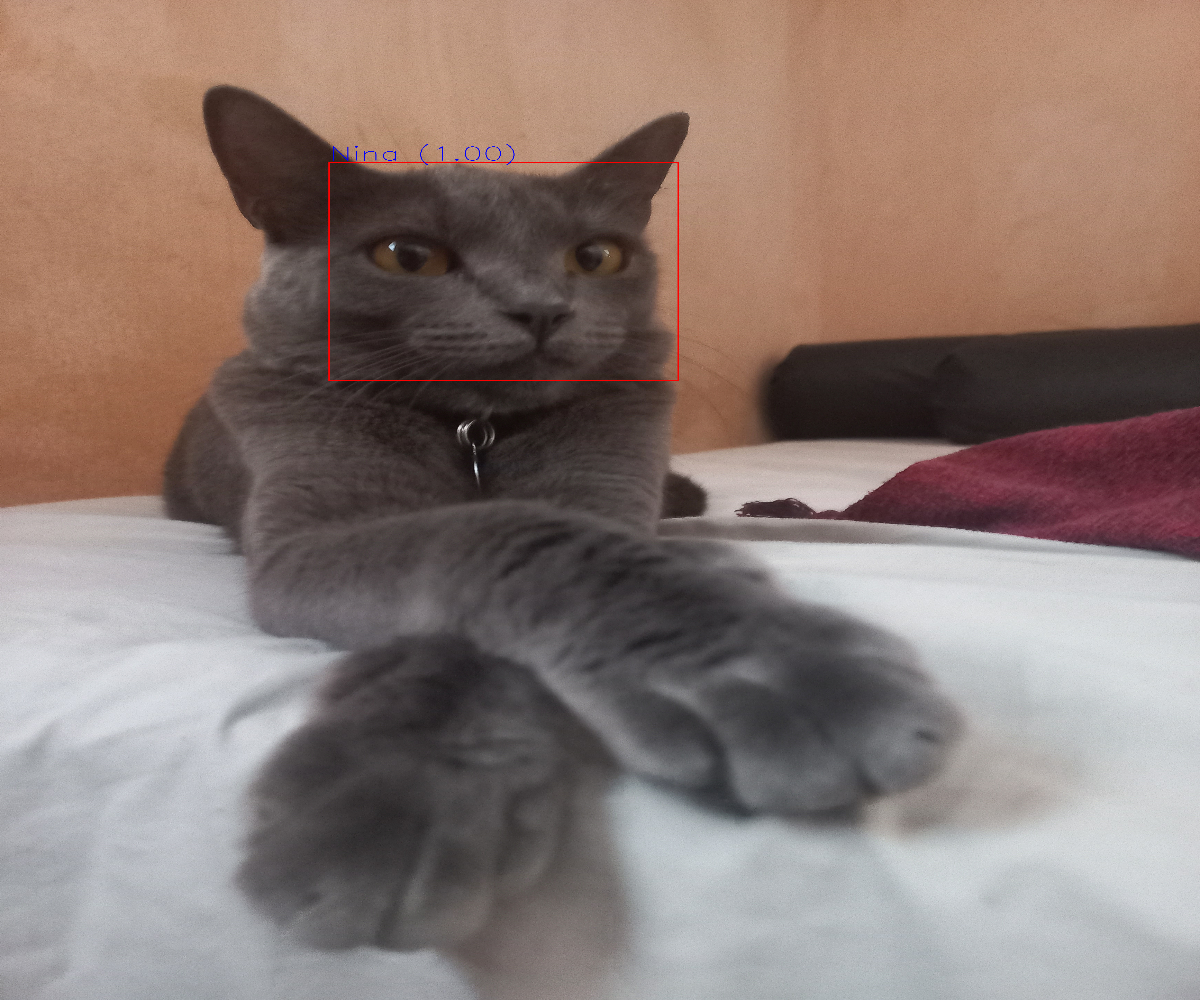

In [51]:
pred_img = cv2.imread('/content/drive/MyDrive/Dataset_DIO/nina/20240411_081848.jpg')
pred_img = detect_and_classify(pred_img)
pred_img = cv2.resize(pred_img, (1200, 1000))
cv2_imshow(pred_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


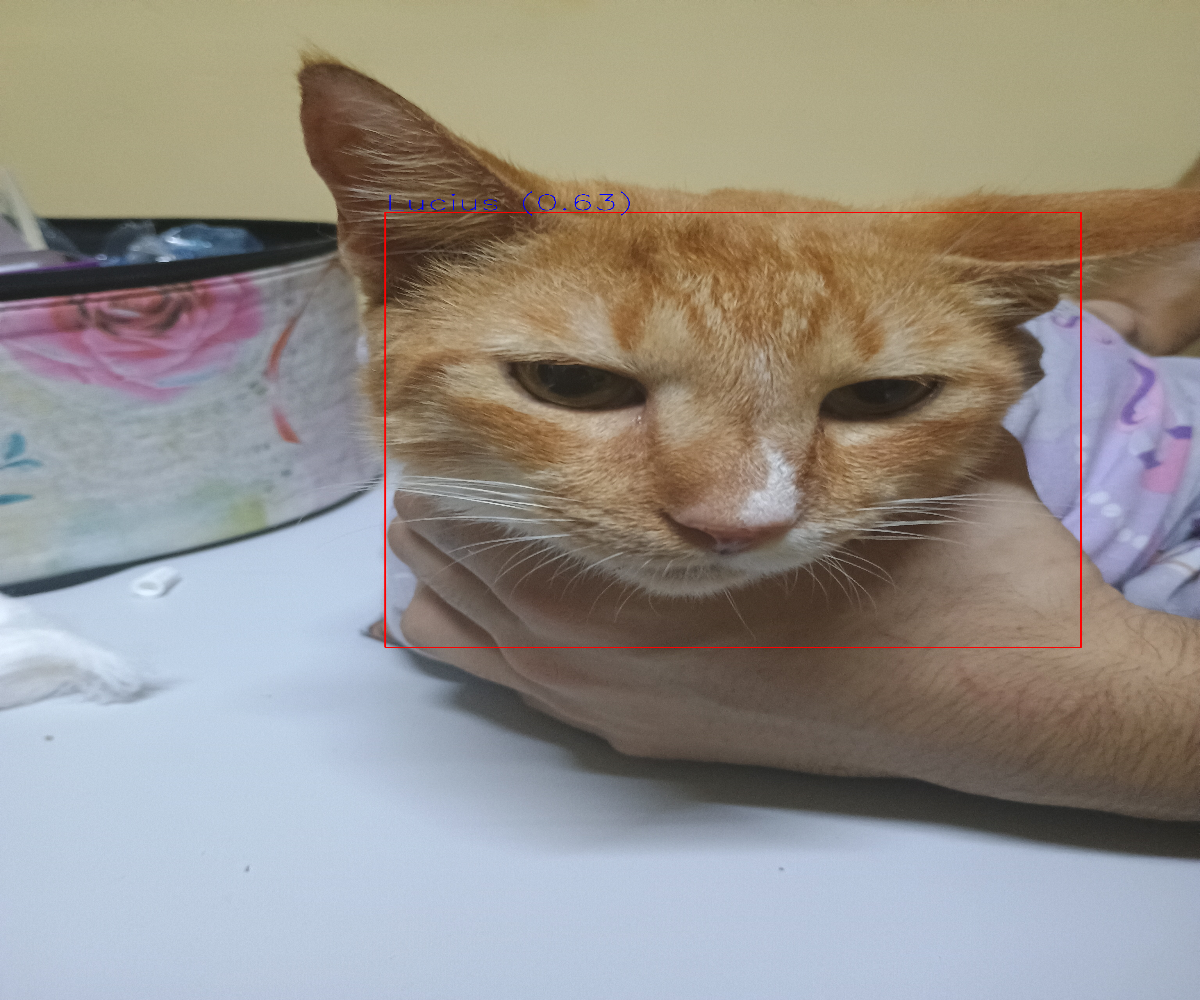

In [50]:
pred_img = cv2.imread("/content/drive/MyDrive/Dataset_DIO/IMG_20250113_192500193_MP.jpg")
pred_img = detect_and_classify(pred_img)
pred_img = cv2.resize(pred_img, (1200, 1000))
cv2_imshow(pred_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


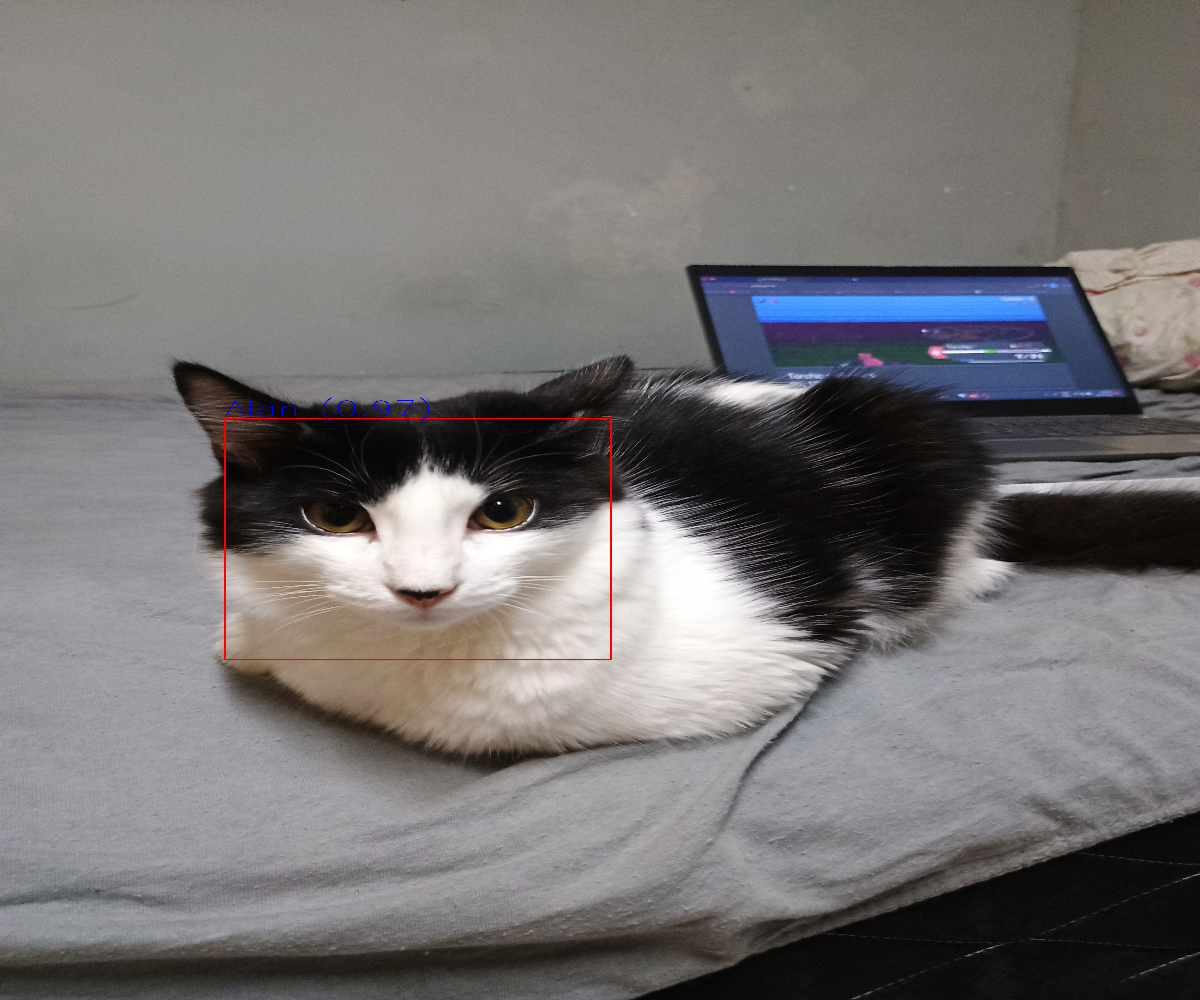

In [53]:
pred_img = cv2.imread("/content/drive/MyDrive/Dataset_DIO/gato/IMG_20241230_201550821_MP.jpg")
pred_img = detect_and_classify(pred_img)
pred_img = cv2.resize(pred_img, (1200, 1000))
cv2_imshow(pred_img)